# Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data and dataset modification

In [2]:
DATA_FOLDER = "../../data/"

PREPROCESSED_CHARACTER_DATASET = DATA_FOLDER+"preprocessed_character_metadata_final.tsv"
movies = pd.read_pickle(DATA_FOLDER+'movies.pkl')
character_metadata = pd.read_csv(PREPROCESSED_CHARACTER_DATASET, sep='\t')
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label']

We want to look at the character ethnicity representation depending on the country. Therefore, we can merge the character dataset with the column from the movie dataset containing the country of each film.  

In [3]:
character_countries = pd.merge(character_metadata,movies[['Wikipedia_movie_ID', 'FirstCountry_Name','SecondCountry_Name']], on = 'Wikipedia_movie_ID')
character_countries.sample(5)


,Wikipedia_movie_ID,Freebase_Movie_ID,Character_Name,Actor_Ethnicity,Actor_Name,Actor_Age_At_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_character_ID,Freebase_Actor_ID,Movie_Release_Year,Ethnicity_Label,FirstCountry_Name,SecondCountry_Name
21429,8120239,/m/026s9vw,Ali's ex-girlfriend,/m/0dryh9k,Aarti Chhabria,24.0,/m/03jr12d,/m/0h77lnf,/m/0g2bkf,2007.0,Indian,India,None
8729,5377390,/m/0dj3_d,Mrs. Dolas,/m/0dryh9k,Amrita Singh,49.0,/m/03jrhqq,/m/0h35lkm,/m/07f49g,2007.0,Indian,India,None
3500,9162935,/m/027zts0,Ashfaq Khan/Sameer Khan,/m/0dryh9k,Ajay Devgan,38.0,/m/02vc0yl,/m/0gyc_cs,/m/044pqn,2008.0,Indian,India,None
70204,1290182,/m/04qf43,Han Ji-yeong,/m/01xhh5,Chu Sang Mi,31.0,/m/040jvhd,/m/0j6qvyp,/m/04cygc,2004.0,Koreans,South Korea,None
64699,14725249,/m/03gvndd,NaN,/m/033tf_,Anthony Michael Hall,23.0,/m/040mn9r,NaN,/m/01jvs4,1992.0,Irish Americans,United States of America,None


## Actor ethnicity in the US vs Rest of the world

We want to analyze the impact of 9/11 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after 9/11. Moreover, we expect for 9/11 to have a higher impact in the US compared to the rest of the world. Therefore, we will compare the data on those levels.

In [4]:
ethnicities_csv = pd.read_csv(DATA_FOLDER+"americans_by_descent.xls")
list_ethnicities = ethnicities_csv.columns[2:]

character = character_countries.copy()
print("length of the dataset: ", len(character))

#Separation into 2 datasets, one with only movies form the US and the other that contains all the other movies
# We use the first and second country associated with the film, if a film second or first country is US he will be in the US dataset otherwise he won't 

character_ROW = character.loc[~character["FirstCountry_Name"].str.contains('United States of America')]
print("length of the ROW dataset: ", len(character_ROW))

character_US = character.loc[character["FirstCountry_Name"].str.contains('United States of America')]
#Look at film which has as first country OR second country United states
additional_US = character_ROW.loc[character_ROW["SecondCountry_Name"].str.contains('United States of America', na=False)]
character_US = pd.concat([character_US, additional_US], ignore_index=True)
character_ROW = character_ROW.loc[~character_ROW.index.isin(additional_US.index)]

#reset the index

character_ROW = character_ROW.reset_index(drop = True)
character_US = character_US.reset_index(drop = True)

length of the dataset:  73797
length of the ROW dataset:  30820


We count the occurence of each ethnicity in both datasets

In [5]:
distribution_ROW = []
distribution_US = []

for eth in list_ethnicities:
    count = character_ROW['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_ROW.append(count)
    count = character_US['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_US.append(count)

In [6]:
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'Rest of the World' : distribution_ROW,
    'United States' : distribution_US
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,Rest of the World,United States
0,African,244,8589
1,Arab,7,52
2,Caribbean,1,0
3,European,2,36
4,Greenlandic,0,0


In [7]:
ethnicity_top10_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_US = character_US['Ethnicity_Label'].value_counts().nlargest(10)

In [8]:
type(ethnicity_top10_ROW)

pandas.core.series.Series

In [9]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
ethnicity_top10_ROW = sorted_ROW['Ethnicity'].head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)
ethnicity_top10_US = sorted_US['Ethnicity'].head(10)

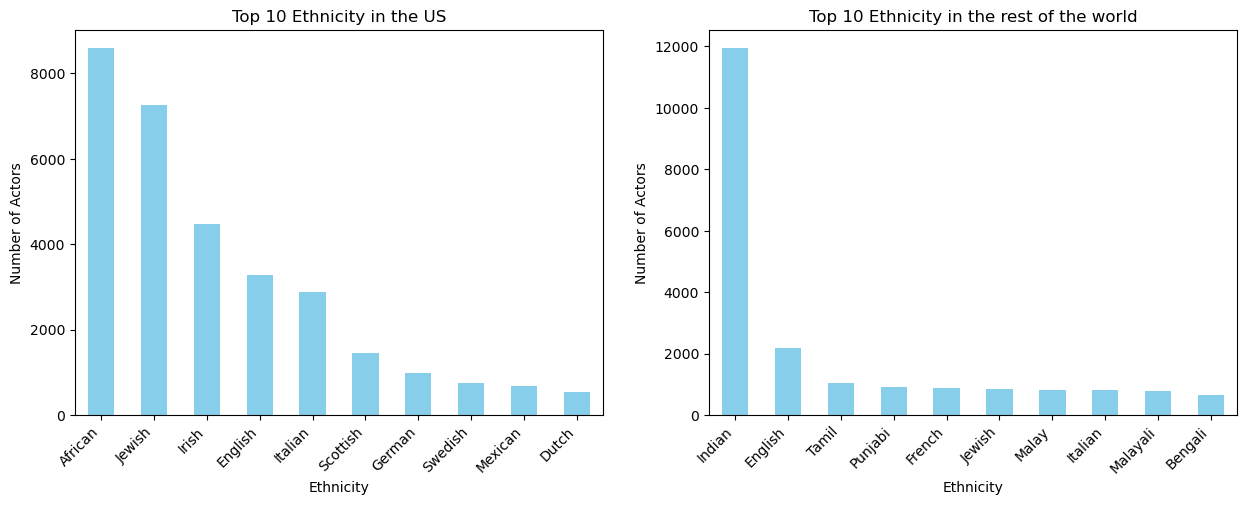

In [10]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)

ethnicity_top10_ROW = sorted_ROW.set_index('Ethnicity')['Rest of the World']
ethnicity_top10_US = sorted_US.set_index('Ethnicity')['United States']

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ethnicity_top10_US.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the US")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
ethnicity_top10_ROW.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the rest of the world")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
# plt.subplots_adjust(wspace=0.5)
plt.show()


We observe the top 10 ethnicty in the rest of the world differ from the top 10 ethnicty within the US. The African Americains is the most represented ethnicity in the US whereas in the rest of the world this is the indian. 

### The impact of 9/11

We will now deep into a reduce period of time, between 1993 and 2010 and observe the difference between ethnicities representation in the US compared to the rest of the world. 

In [11]:
# First for the US movies, we will filter the data for movies released between 1993 and 2001 and between 2002 and 2010,
# and study the most common ethnicities for these time periods.

#  Filter data for movies released between 1990 and 2001
data_1993_2001_US = character_US[(character_US['Movie_Release_Year'] >= 1993) & 
                                    (character_US['Movie_Release_Year'] <= 2001)]
data_2002_2010_US = character_US[(character_US['Movie_Release_Year'] >= 2002) & 
                                    (character_US['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_US = character_US['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_US = data_1993_2001_US[data_1993_2001_US['Ethnicity_Label'].isin(top_ethnicities_US)]
data_2002_2010_top_US = data_2002_2010_US[data_2002_2010_US['Ethnicity_Label'].isin(top_ethnicities_US)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_US = data_1993_2001_top_US['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_US = data_2002_2010_top_US['Ethnicity_Label'].value_counts(normalize=True)

We apply the same procedure for the rest of the world

In [12]:
#  Filter data for movies released between 1990 and 2001
data_1993_2001_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 1993) & 
                                    (character_ROW['Movie_Release_Year'] <= 2001)]
data_2002_2010_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 2002) &
                                    (character_ROW['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_ROW = data_1993_2001_ROW[data_1993_2001_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]
data_2002_2010_top_ROW = data_2002_2010_ROW[data_2002_2010_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_ROW = data_1993_2001_top_ROW['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_ROW = data_2002_2010_top_ROW['Ethnicity_Label'].value_counts(normalize=True)

We can now plot the proportion of actor among the 10 most represented ethnicities, for the US and the rest of the world, and compare to see whether there is a different distribution in the two time periods.

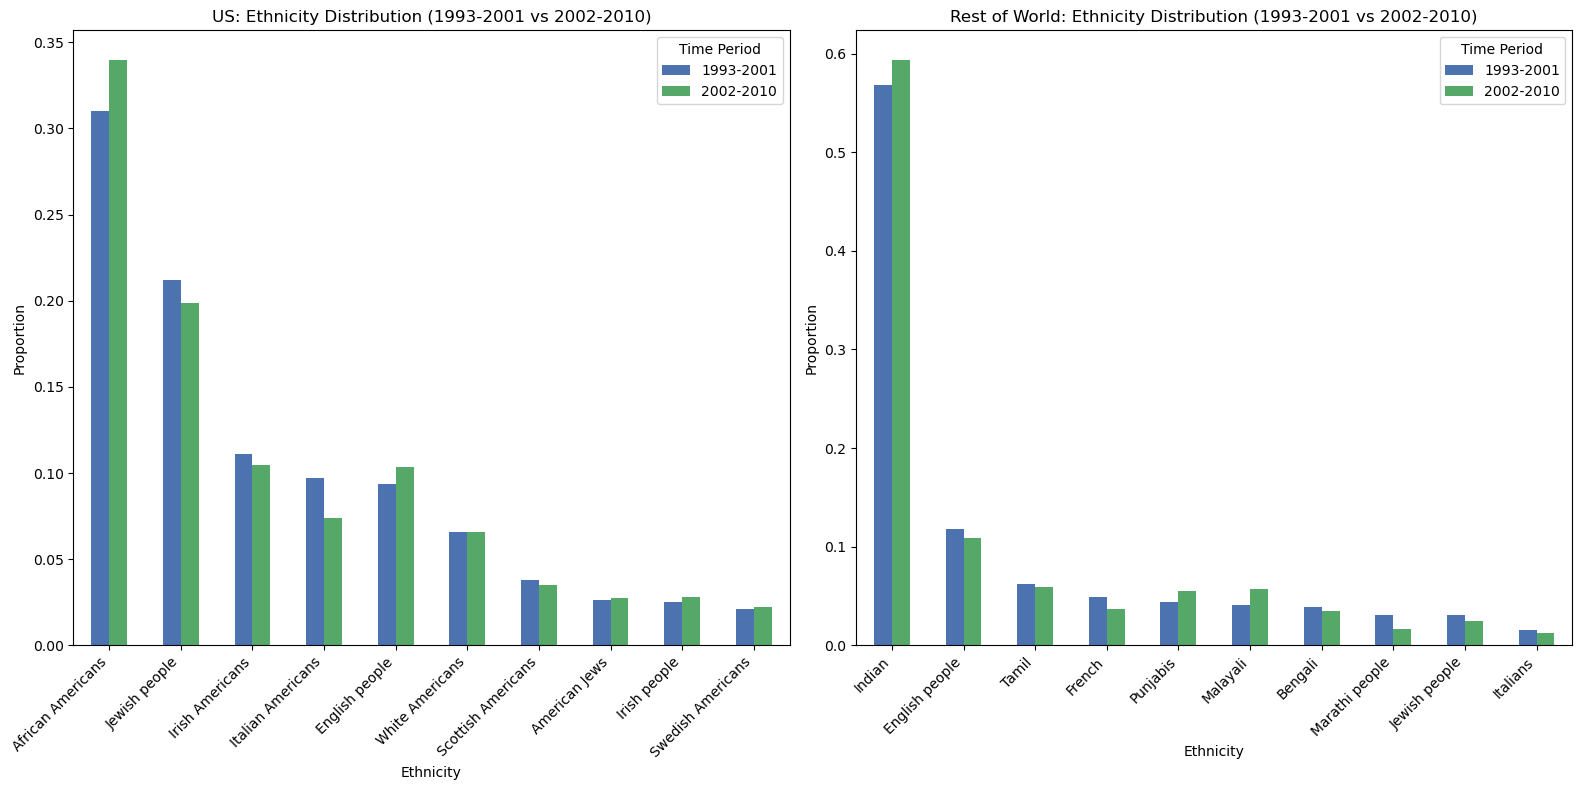

In [13]:

# Convert ethnicity counts to DataFrames for easier plotting
df_US = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_US.index,
    '1993-2001': ethnicity_counts_1993_2001_US.values,
    '2002-2010': ethnicity_counts_2002_2010_US.reindex(ethnicity_counts_1993_2001_US.index, fill_value=0).values
})

df_ROW = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_ROW.index,
    '1993-2001': ethnicity_counts_1993_2001_ROW.values,
    '2002-2010': ethnicity_counts_2002_2010_ROW.reindex(ethnicity_counts_1993_2001_ROW.index, fill_value=0).values
})

# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for US
df_US.set_index('Ethnicity').plot(
    kind='bar', ax=axes[0], color=['#4c72b0', '#55a868']
)
axes[0].set_title('US: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Ethnicity')
axes[0].legend(title="Time Period")
axes[0].set_xticklabels(df_US['Ethnicity'], rotation=45, ha="right")

# Plot for Rest of World
df_ROW.set_index('Ethnicity').plot(
    kind='bar', ax=axes[1], color=['#4c72b0', '#55a868']
)
axes[1].set_title('Rest of World: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Ethnicity')
axes[1].legend(title="Time Period")
axes[1].set_xticklabels(df_ROW['Ethnicity'], rotation=45, ha="right")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


We observe there is no major changes in the top 10 actor ethnicities representation in the movies between 1993 and 2010 neither in the rest of the world or the United States.

Finally, we want to isolate the actor ethnicities that exhibit major changes before and after 9/11. Therefore, we will look at the top 10  actor ethnicites that exxhibit larger relative changes ratio. 

In [14]:
# Count the occurrences of each ethnicity in each period for rest of the world and US 
ethnicity_counts_1993_2001_US = data_1993_2001_US['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_US = data_2002_2010_US['Ethnicity_Label'].value_counts()

ethnicity_counts_1993_2001_ROW = data_1993_2001_ROW['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_ROW = data_2002_2010_ROW['Ethnicity_Label'].value_counts()

# We compute the relative changes for each ethnicites between 1991 and 2011
#Use absolute value to avoid the negative value and for subsequnet isolation of smaller and largest relative difference 
ratio_US = np.abs(ethnicity_counts_1993_2001_US - ethnicity_counts_2002_2010_US) / (ethnicity_counts_1993_2001_US)
ratio_ROW = np.abs(ethnicity_counts_1993_2001_ROW - ethnicity_counts_2002_2010_ROW) / (ethnicity_counts_1993_2001_ROW)


# Sort by the ratio to find the largest 
largest_ratios_US = ratio_US.nlargest(10)
largest_ratios_ROW = ratio_ROW.nlargest(10)

print("US: 5 Largest Ratios: \n \n", largest_ratios_US)
print("\n \n Rest of the world: 5 Largest Ratios:\n \n", largest_ratios_ROW)

US: 5 Largest Ratios: 
 
 Ethnicity_Label
Japanese people         25.00
Chinese Canadians       14.00
Ukrainians              13.00
Gujarati people         11.50
Eurasian                11.00
Croatian Canadians       7.00
Dominican Americans      6.75
Norwegians               6.50
Croatian Australians     6.00
Filipino people          6.00
Name: count, dtype: float64

 
 Rest of the world: 5 Largest Ratios:
 
 Ethnicity_Label
Tulu people             27.000000
Chinese Filipino        25.333333
Filipino people         18.000000
Sikh                    13.000000
English Australian      10.000000
Filipino Australians     8.000000
Lao people               8.000000
British Americans        7.000000
Jaat                     6.000000
Ukrainians               6.000000
Name: count, dtype: float64


We observe ratios larger than 1 meaning they exhibit significant differences between the 2 observed periods, i.e before and after 9/11. From this first analysis, we do not observe any tendency of impact of 9/11 on racism. 

# World war 2

We will now focus on another event: World War II. Our aim is to analyze its impact on the ethnic composition of actors in films. Specifically, we will examine the changes in actor ethnicity before and after World War II. Additionally, we anticipate that World War II had a greater and earlier impact on Europe compared to the United States. Therefore, we will compare the data at several regional levels. Moreover, we will build a further analysis on German and Jewish, the ethnicity that are supposed to experienced the greatest impact after Wolrd War 2.

For world war 2 we are interested in the impact on every continent therefore we will split the dataset according to continent. To do so we will use an additional dataset : continents.csv. This dataset allows the mapping of each country related to the movie to a continent: Africa, North America, South America, Europe and Asia. 

In [15]:
def map_continent(movie_country, continent_data_frame):
    label = continent_data_frame[continent_data_frame['Entity'] == movie_country]['World regions according to OWID']
    if len(label) > 0:
        return label.values[0]
    else:
        return None
continent_mapping_df = pd.read_csv(DATA_FOLDER+"continents.csv",sep=';')
continent_mapping_df.columns = ['Entity','World regions according to OWID']

In [16]:
def map_dataset(character):
    character.reset_index(drop=True, inplace=True)
    #Association for each character to two continent corresponding to First and Second country name (isolated during preprocessing)
    for i in range(len(character)):
        labels = map_continent(character['FirstCountry_Name'].iloc[i], continent_mapping_df)
        labels2 = map_continent(character['SecondCountry_Name'].iloc[i], continent_mapping_df)
        character.at[i, 'Continent'] = labels
        character.at[i,'Second_Continent'] = labels2
    return character

In [17]:
character = map_dataset(character)

In [18]:
character.columns

Index(['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label',
       'FirstCountry_Name', 'SecondCountry_Name', 'Continent',
       'Second_Continent'],
      dtype='object')

In [19]:
#Get the list of all the ethnicities present in the dataset
list_ethnicities = list(set(character['Ethnicity_Label']))
print("length of the dataset: ", len(character))

#Separation into 5 datasets, one for North America, one for South America, one Europe, one Asia and one for Africa
#We chose to separate into 4 datasets in order to have enough data
#Count a film two times if he takes place both in Europe and in North America for example 
character_EU = character.loc[(character['Continent']=='Europe') | (character['Second_Continent']== 'Europe')]
character_NA = character.loc[(character['Continent']=='North America') | (character['Second_Continent']=='North America')]
character_AS = character.loc[(character['Continent']=='Asia') | (character['Second_Continent']=='Asia')]
character_SA = character.loc[(character['Continent']=='South America') | (character['Second_Continent']=='South America')]
character_AF = character.loc[(character['Continent']=='Africa') | (character['Second_Continent']=='Africa')]

#reset the index
character_EU = character_EU.reset_index(drop = True)
character_NA = character_NA.reset_index(drop = True)
character_AS = character_AS.reset_index(drop = True)
character_SA = character_SA.reset_index(drop = True)
character_AF = character_AF.reset_index(drop = True)


length of the dataset:  73797


We count the occurence for each ethnicities in the four dataset:

In [39]:
distribution_NA = []
distribution_AS = []
distribution_SA = []
distribution_AF = []
distribution_EU = []

for eth in list_ethnicities:
    count = character_NA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_NA.append(count)
    count = character_AS['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AS.append(count)
    count = character_SA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_SA.append(count)
    count = character_AF['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AF.append(count)
    count = character_EU['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_EU.append(count)


In [21]:
#Construct a dictionary with the propention of every ethnicities for each continent 
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'North America' : distribution_NA,
    'South America' : distribution_SA,
    'Africa' : distribution_AF,
    'Asia' : distribution_AS,
    'Europe' : distribution_EU
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,North America,South America,Africa,Asia,Europe
0,Germans,297,0,4,10,254
1,Bengali,34,0,2,645,13
2,Portuguese Americans,99,1,0,0,8
3,Blackfoot Confederacy,38,0,0,0,4
4,Serbian Americans,100,0,0,0,11


In [22]:
#Sort ethnicities distribution and isolate the top 10
sorted_NA = ethnicities_distribution.sort_values(by='North America', ascending=False).head(10)
ethnicity_top10_NA = sorted_NA['Ethnicity'].head(10)
sorted_SA = ethnicities_distribution.sort_values(by='South America', ascending=False).head(10)
ethnicity_top10_SA = sorted_SA['Ethnicity'].head(10)
sorted_AS = ethnicities_distribution.sort_values(by='Asia', ascending=False).head(10)
ethnicity_top10_AS = sorted_AS['Ethnicity'].head(10)
sorted_AF = ethnicities_distribution.sort_values(by='Africa', ascending=False).head(10)
ethnicity_top10_AF = sorted_AF['Ethnicity'].head(10)
sorted_EU = ethnicities_distribution.sort_values(by='Europe', ascending=False).head(10)
ethnicity_top10_EU = sorted_EU['Ethnicity'].head(10)

In [40]:
def plot_all_eth(regions):
    plt.figure(figsize=(15, 10))

    for i, (region, data) in enumerate(regions.items(), 1):
        plt.subplot(2, 3, i)
        data.plot(kind='bar', color='skyblue')
        plt.title(f"Top 10 Ethnicity in {region}")
        plt.xlabel("Ethnicity")
        plt.ylabel("Number of Actors")
        plt.xticks(rotation=45, ha='right')

    plt.subplots_adjust(wspace=0.5, hspace=1.5)
    plt.show()

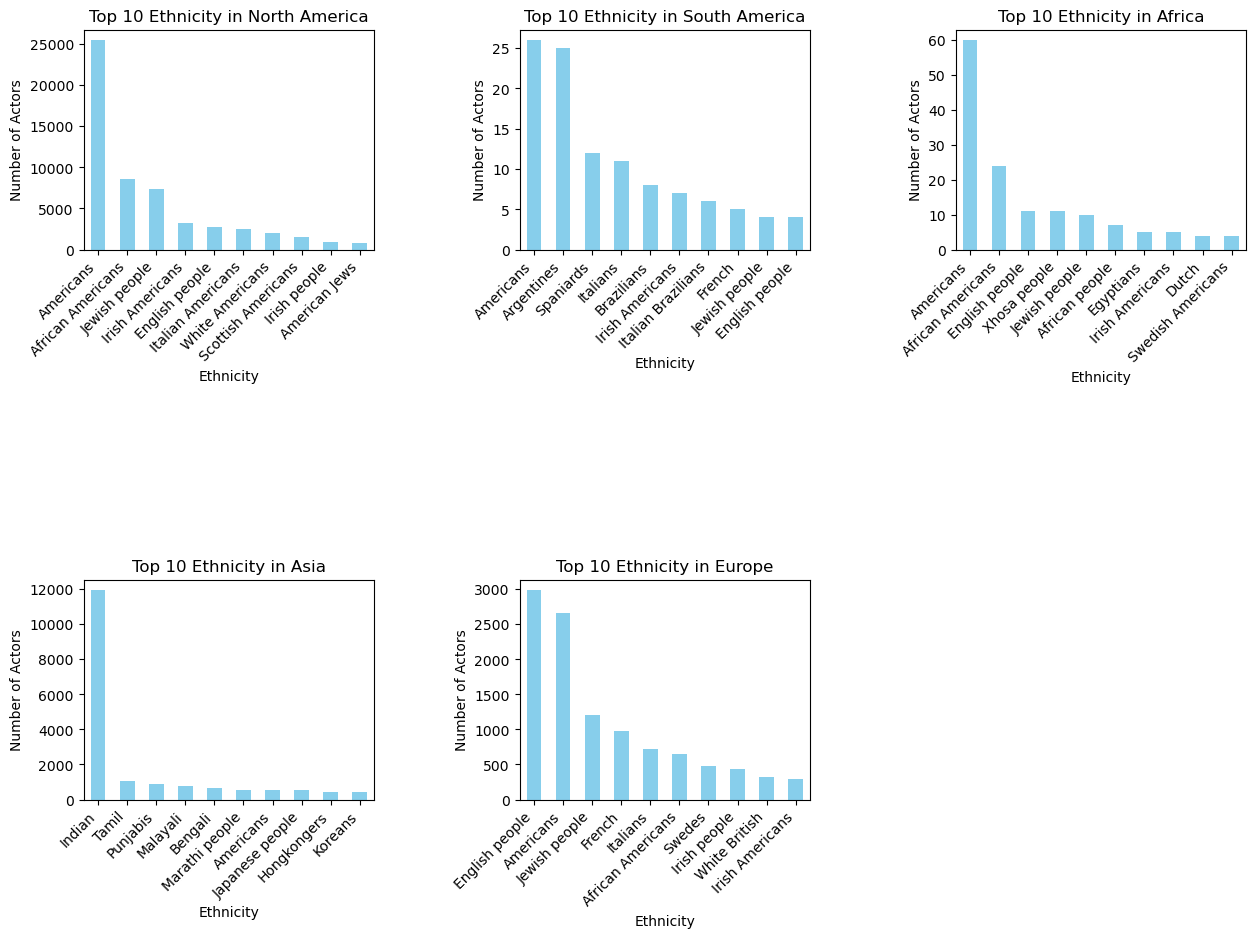

In [41]:
regions = {
    'North America': sorted_NA.set_index('Ethnicity')['North America'],
    'South America': sorted_SA.set_index('Ethnicity')['South America'],
    'Africa': sorted_AF.set_index('Ethnicity')['Africa'],
    'Asia': sorted_AS.set_index('Ethnicity')['Asia'],
    'Europe': sorted_EU.set_index('Ethnicity')['Europe']
}
plot_all_eth(regions)


We observe the ethnicities greatly varies upon the continent. In Europe the most important ethnicities is English people whereas in Asia it is Indian. Moreover we observe the Jewish people are highly represented in Europe and in north America. 
However, in Asia, Africa and South America the number of actors seems very low compared to what we expect to build a solid analysis. We will need further investigation on the size and the quality of those data. 

We are now interested in looking at ethnicities distribution on specific year. Therefore, we want to observe if they vary across time. For the sake of our analysis we will look at the year 1942 and 2010. 

In [24]:
def extract_top_10(df):

    list_ethnicities = list(set(character['Ethnicity_Label']))

    distribution = []

    for eth in list_ethnicities:
        count = df['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
        distribution.append(count)

    ethnicities_dict = {
        'Ethnicity' : list_ethnicities,
        'Occurences' : distribution
    }

    ethnicities_distribution = pd.DataFrame(ethnicities_dict)
    sorted_df = ethnicities_distribution.sort_values(by='Occurences', ascending=False).head(10)
    ethnicity_top10 = sorted_df['Ethnicity'].head(10)

    return ethnicities_distribution, ethnicity_top10

In [25]:
#Return for a specific year the top 10 ethnicities 
def eth_per_year(data,year):
    data_new = data.loc[data['Movie_Release_Year'] == year]
    distribution, top_10 = extract_top_10(data_new)

    return distribution, top_10

In [26]:
character.columns

Index(['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label',
       'FirstCountry_Name', 'SecondCountry_Name', 'Continent',
       'Second_Continent'],
      dtype='object')

In [27]:
def plot_10_ethnicties(counts,year):
    """
    Plots the top 10 ethnicities for a given year based on occurrence counts.
    
    Parameters:
        counts (DataFrame): A DataFrame containing 'Ethnicity' and 'Occurences' columns.
        year (int): The year for which the plot is generated.
    """
    df_2010 = pd.DataFrame({ 
        'Ethnicity': counts['Ethnicity'],
        'year': counts['Occurences'],
    })  
    # Plot for 2010
    df_2010.set_index('Ethnicity').plot(kind='bar', color='skyblue', legend=False)
    plt.title(f'Top 10 Ethnicities in {year}')
    plt.ylabel('Occurences')
    plt.xlabel('Ethnicity')
    plt.tight_layout()
    plt.show()

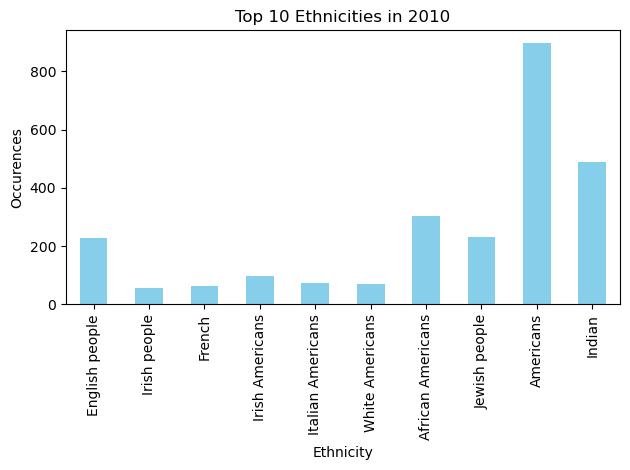

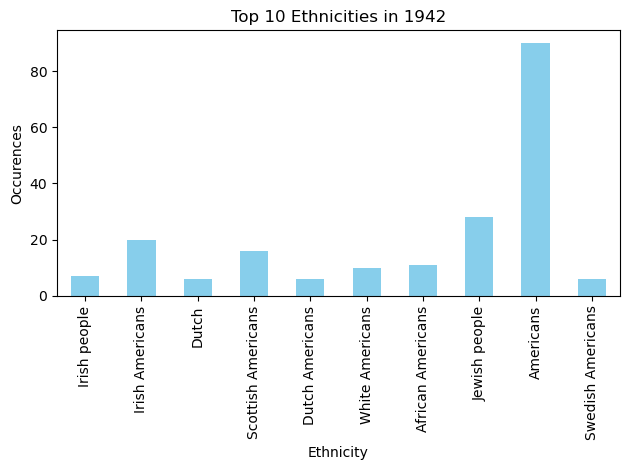

In [28]:
distribution = {}

#Plot top 10 ethncities for 1942 and 2010
distribution['2010'], data_2010_top_10 = eth_per_year(character,2010)
distribution['1942'], data_1942_top_10 = eth_per_year(character,1942)
counts_2010 = distribution['2010'][distribution['2010']['Ethnicity'].isin(data_2010_top_10)]
counts_1942 = distribution['1942'][distribution['1942']['Ethnicity'].isin(data_1942_top_10)]
plot_10_ethnicties(counts_2010,2010)
plot_10_ethnicties(counts_1942,1942)

We observe several differences between 1942 and 2010 worldwide. For example, we obsevre in 2010 the number of Indians greatly increased compared to 1942. This might be explained by the emergence of Asian cinematography. However, other factor can explained shift observed throughout the years abd most importantly does certain historical event can influence the proportion opf a certain ethnicity in cinema. 

## Impact of World War 2

We will now deep into a reduce period of time, between 1937 and 1948 and observe the difference between ethnicities representation in the North America, South America, Europe, Asia and Africa. We chose a small time range to avoid confounding factors. 

In [29]:
def ethnicity_count(regions):
    '''
    Analyzes ethnicity distribution for movie data across specified time periods and regions.

    Args:
        regions (dict): A dictionary where keys are region names and values are pandas DataFrames 
                        containing movie data. Each DataFrame must include 'Movie_Release_Year' 
                        and 'Ethnicity' columns.

    Returns:
         - ethnicity_counts_1937_1941 (dict): Counts of top 10 ethnicities for 1937–1941.
         - ethnicity_counts_1942_1948 (dict): Counts of top 10 ethnicities for 1942–1948.
         - data_1937_1948 (dict): Filtered data for 1937–1948 by region.
         - distribution_1937_1941 (dict): Ethnicity distribution for 1937–1941 by region.
         - distribution_1942_1948 (dict): Ethnicity distribution for 1942–1948 by region.
    '''
    # Initialize dictionaries to store results for each region
    # Initialize dictionaries to store results for each region
    ethnicity_counts_1937_1941 = {}
    ethnicity_counts_1942_1948 = {}
    data_1937_1948 = {}
    ethnicities_distribution = {}
    distribution_1937_1941 = {}
    distribution_1942_1948 = {}
    for region_name, region_data in regions.items():
    # Filter data for the year ranges
        data_1937_1941 = region_data[
            (region_data['Movie_Release_Year'] >= 1937) & 
            (region_data['Movie_Release_Year'] <= 1941)
        ]
        data_1942_1948 = region_data[
            (region_data['Movie_Release_Year'] >= 1942) & 
            (region_data['Movie_Release_Year'] <= 1948)
        ]
        data_1937_1948[region_name] = region_data[
            (region_data['Movie_Release_Year'] >= 1937) & 
            (region_data['Movie_Release_Year'] <= 1948)
        ]

        
        ethnicities_distribution[region_name], top_ethnicities = extract_top_10(data_1937_1948[region_name])

        #Extract top 10 for given time range
        distribution_1937_1941[region_name], _ = extract_top_10(data_1937_1941)
        distribution_1942_1948[region_name], _ = extract_top_10(data_1942_1948)
        #Isolate the one being in the top 10 ethnicities
        counts_1937_1941 = distribution_1937_1941[region_name][distribution_1937_1941[region_name]['Ethnicity'].isin(top_ethnicities)]
        counts_1942_1948 = distribution_1942_1948[region_name][distribution_1942_1948[region_name]['Ethnicity'].isin(top_ethnicities)]


        ethnicity_counts_1937_1941[region_name] = counts_1937_1941
        ethnicity_counts_1942_1948[region_name] = counts_1942_1948
    return ethnicity_counts_1937_1941,ethnicity_counts_1942_1948,data_1937_1948,distribution_1937_1941,distribution_1942_1948

In [30]:
# First for each regions, we will filter the data for movies released between 1937 and 1941 and between 1941 and 1948,
regions = {
    'NA': character_NA,
    'SA': character_SA,
    'AS': character_AS,
    'EU': character_EU,
    'AF': character_AF
}
ethnicity_counts_1937_1941,ethnicity_counts_1942_1948,data_1937_1948,distribution_1937_1941,distribution_1942_1948 = ethnicity_count(regions)


We can now plot the proportion of actor among the 10 most represented ethnicities, for the different regions, and compare to see whether there is a different distribution in the five time periods.

In [37]:
def form_df(ethnicity_counts_1937_1941,ethnicity_counts_1942_1948):
    """
    Converts ethnicity counts for different regions into DataFrames for easier plotting and analysis.

    Returns:
        dict: A dictionary where each key is a region (e.g., 'North Americas', 'South America', 'Asia', 'Africa', 'Europe')
              and each value is a DataFrame containing ethnicity counts for two time periods: '1937-1941' and '1942-1948'.
    """
    # Convert ethnicity counts to DataFrames for easier plotting
    df_NA = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['NA']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['NA']['Occurences'],
        '1942-1948': ethnicity_counts_1942_1948['NA']['Occurences']
    })

    df_SA = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['SA']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['SA']['Occurences'],
        '1942-1948': ethnicity_counts_1942_1948['SA']['Occurences']
    })
    df_AS = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['AS']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['AS']['Occurences'],
        '1942-1948': ethnicity_counts_1942_1948['AS']['Occurences']
    })
    df_AF = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['AF']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['AF']['Occurences'],
        '1942-1948': ethnicity_counts_1942_1948['AF']['Occurences']
    })
    df_EU = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['EU']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['EU']['Occurences'],
        '1942-1948': ethnicity_counts_1942_1948['EU']['Occurences']
    })

    #We want to isolate the relevant continent, therefore we look at their ethnicity count and choose 50 as threshold for count in each continent
    regions = {'North Americas':df_NA,'South America': df_SA,'Asia': df_AS,'Africa': df_AF,'Europe': df_EU}
    return regions



In [32]:
def display_length_eth(regions):
    """
    Displays the total number of entries for the '1937-1941' and '1942-1948' columns for each region.

    Args:
        regions (dict): A dictionary where each key is a region name (e.g., 'North America', 'Europe') and each value 
                        is a DataFrame containing at least the columns '1937-1941' and '1942-1948', 
                        representing the counts of ethnicities in these time periods.

    Returns:
        None: Prints out the total count for each region and time period.
    """
    for region_name,region_df in regions.items():
        print(f"Region: {region_name} has {region_df['1937-1941'].sum()} entries in '1937-1941' and {region_df['1942-1948'].sum()} '1942-1948'.")
        

In [38]:
regions = form_df(ethnicity_counts_1937_1941,ethnicity_counts_1942_1948)
#We want to isolate the relevant continent, therefore we look at their ethnicity count 
display_length_eth(regions)      

Region: North Americas has 820 entries in '1937-1941' and 1216 '1942-1948'.
Region: South America has 0 entries in '1937-1941' and 4 '1942-1948'.
Region: Asia has 26 entries in '1937-1941' and 73 '1942-1948'.
Region: Africa has 0 entries in '1937-1941' and 0 '1942-1948'.
Region: Europe has 60 entries in '1937-1941' and 96 '1942-1948'.


We observe that South America and Africa have little to no data entries for the observed period. As a result, these data are insufficient for a robust analysis. Additionally, while Asia has a small amount of data, it does not offers valuable insights for our study, that will be axed on Germans and Jews character representation. Therefore, our subsequent analysis will primarily focus on Europe and North America.

In [63]:
def plot_eth(regions,titles):
    '''
    Plots ethnicity distribution for each region across two time periods (1937–1941 and 1942–1948).

    Args:
        regions (list): A list of pandas DataFrames, where each DataFrame contains:
                        - 'Ethnicity': A column for ethnicity names.
                        - Other columns for the time period counts (e.g., '1937–1941' and '1942–1948').
        titles (list): A list of titles corresponding to the regions, used for plot annotations.

    Returns:
        None: Displays the plots. 
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.flatten()
    #Plot each DataFrame
    for i, (df, title) in enumerate(zip(regions, titles)):
        df.set_index('Ethnicity').plot(
            kind='bar',
            ax=axes[i],  # Use flattened axis array
            color=['#4c72b0', '#55a868']
        )
        axes[i].set_title(f'{title}\n (1937-1941 vs 1942-1948)')
        axes[i].set_ylabel('Occurences')
        axes[i].set_xlabel('Ethnicity')
        axes[i].legend(title="Time Period")
        axes[i].set_xticklabels(df['Ethnicity'], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


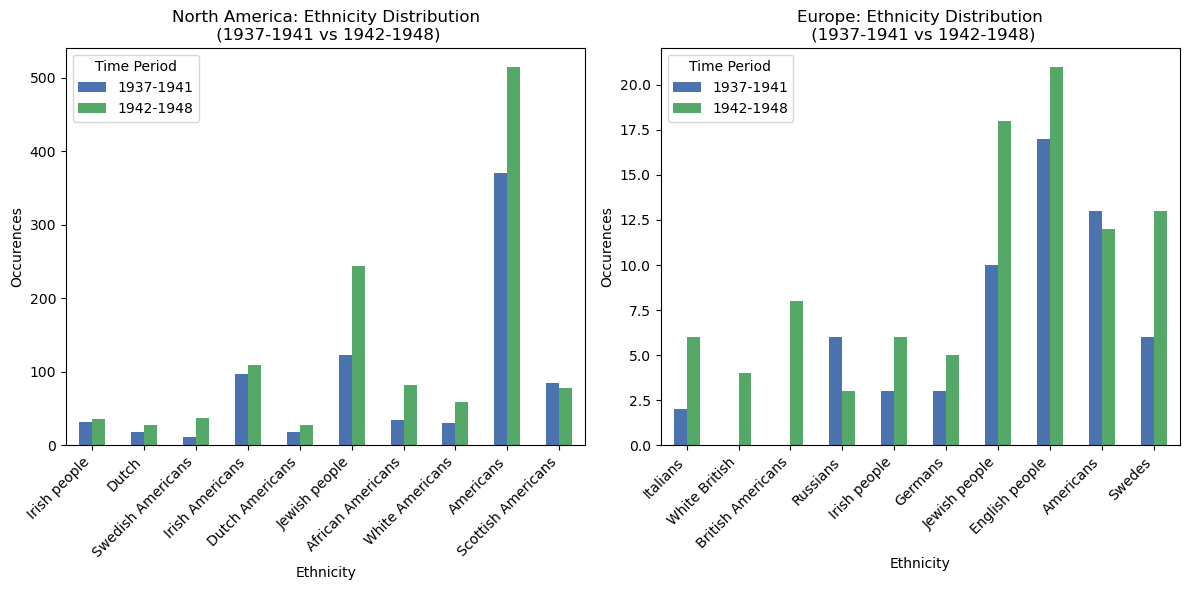

In [64]:
#Plot the Ethnicity distribution before and after World War II
regions_2 =[regions['North Americas'], regions['Europe']]
titles = [
    'North America: Ethnicity Distribution',
    'Europe: Ethnicity Distribution']
# Plot each DataFrame
plot_eth(regions_2,titles)

Before and after WWII we observe an increase in Jewish people representation in movies in North America as well as movies in Europe. This trands is also observed for Americans in North America and Swedes and Germans in Europe. However, we look here at the total number. To a more precise analysis we need to take into account the total number of movies. Therefore we look at the proportion instead of absolute occurence. 

We now repeat the exact same procedure, but we use proportions instead of absolute occurences.

In [82]:
def percentage_df(ethnicity_counts_1937_1941,ethnicity_counts_1942_1948):
    """
    Converts ethnicity counts for North America (NA) and Europe (EU) into percentage form
    for the years 1937-1941 and 1942-1948. This allows for easy comparison of the proportion 
    of different ethnicities in these two time periods.

    Args:
        ethnicity_counts_1937_1941 (dict): A dictionary containing ethnicity counts for the year 1937-1941. 
            - The dictionary keys should be 'NA' and 'EU', each containing a DataFrame with:
                - 'Ethnicity' column (the ethnicity names).
                - 'Occurences' column (the count of occurrences for each ethnicity).
        ethnicity_counts_1942_1948 (dict): A similar dictionary containing ethnicity counts for the years 1942-1948.

    Returns:
        list: A list containing two DataFrames:
            - One for North America (NA) showing the percentage of each ethnicity in the two time periods.
            - One for Europe (EU) showing the same.
    """
    # Convert ethnicity counts to DataFrames for easier plotting
    df_NA_percentage = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['NA']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['NA']['Occurences']/ethnicity_counts_1937_1941['NA']['Occurences'].sum(),
        '1942-1948': ethnicity_counts_1942_1948['NA']['Occurences']/ethnicity_counts_1942_1948['NA']['Occurences'].sum()
    })

    df_EU_percentage = pd.DataFrame({
        'Ethnicity': ethnicity_counts_1937_1941['EU']['Ethnicity'],
        '1937-1941': ethnicity_counts_1937_1941['EU']['Occurences']/ethnicity_counts_1937_1941['EU']['Occurences'].sum(),
        '1942-1948': ethnicity_counts_1942_1948['EU']['Occurences']/ethnicity_counts_1942_1948['EU']['Occurences'].sum()
    })
    df_percentage = [df_NA_percentage,df_EU_percentage]
    return df_percentage

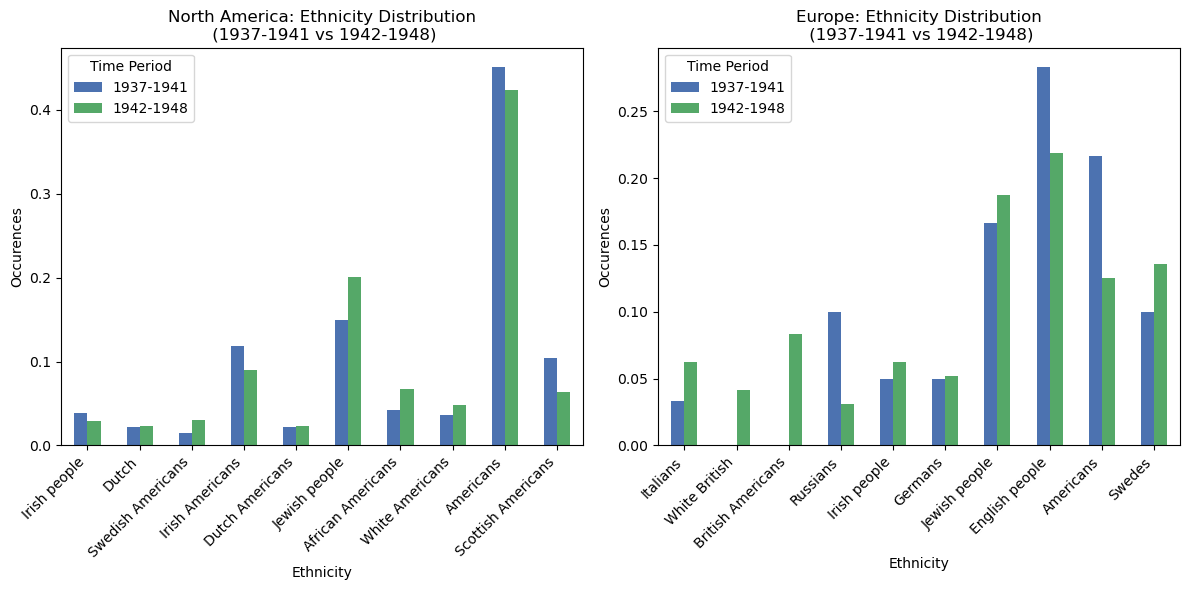

In [72]:
regions_percentage = percentage_df(ethnicity_counts_1937_1941,ethnicity_counts_1942_1948)
titles = [
    'North America: Ethnicity Distribution',
    'Europe: Ethnicity Distribution'
]
plot_eth(regions_percentage,titles)

By looking at proportions we observe still an increase in Jewish people before and after WWII in North America, but smaller changes were observed in Europe. Morever, where we observe an increasing tendency in the previous plot for Germans representation in Europe, we do not observe any changes by looking at the proportion. Same observation can be done on Americans in North America.

In [76]:
def ratio(df_regions):
    """
    Computes the ratio of change between two time periods (1937-1941 and 1942-1948)
    for North America and Europe and identifies the 5 largest changes for each region.

    Args:
        df_regions (list): A list of DataFrames, where:
            - df_regions[0] is the DataFrame for North America.
            - df_regions[1] is the DataFrame for Europe.
            Each DataFrame must have columns: '1937-1941', '1942-1948', and 'Ethnicity'.

    Returns:
        list: The modified list of DataFrames (with 'Ratio' column added).
    """
    df_NA = df_regions[0]
    df_EU = df_regions[1]
    df_NA['Ratio'] = -(df_NA['1937-1941'] - df_NA['1942-1948']) / (df_NA['1937-1941'])
    df_EU['Ratio'] = -(df_EU['1937-1941'] - df_EU['1942-1948']) / (df_EU['1937-1941'])
    # Sort by the ratio to find the largest 
    largest_ratios_NA = df_NA.sort_values(by='Ratio', ascending=False).head(5)
    largest_ratios_EU = df_EU.sort_values(by='Ratio', ascending=False).head(5)

    print("North America: 5 Largest Ratios: \n \n", largest_ratios_NA)
    print("\n \n Europe: 5 Largest Ratios:\n \n", largest_ratios_EU)

In [77]:
ratio(regions_2)

North America: 5 Largest Ratios: 
 
              Ethnicity  1937-1941  1942-1948     Ratio
68   Swedish Americans         12         37  2.083333
105  African Americans         35         82  1.342857
80       Jewish people        123        244  0.983740
129    White Americans         30         59  0.966667
59               Dutch         18         28  0.555556

 
 Europe: 5 Largest Ratios:
 
              Ethnicity  1937-1941  1942-1948     Ratio
17       White British          0          4       inf
30   British Americans          0          8       inf
2             Italians          2          6  2.000000
168             Swedes          6         13  1.166667
54        Irish people          3          6  1.000000


In North America, we observe a consequent increase in the number of Jewish people. This was not observed in Europe. The other ratio are not relevant for the analysis of the impact of WWII and might be due to cofounding factors.  

### Impact on Jewish and German representation

World War 2 had a major impact on Jewish and German population. We therefore are now interested to see if this impact is visible on actor ethnicity prevalence before and after World War 2 in the movies. Therefore, we will investigate the presence of Jewish and German in actor ethnicity before and after Wolrd War 2.

In [75]:
def plot_trend(eu_german_trend,na_german_trend,title1, title2,title3):
    '''
    Plots the trend of German characters in movies for Europe and North America over time,
    with a vertical line marking the end of World War II (1945).

    Args:
        eu_german_trend (list or array): The trend of German characters in European movies over time.
        na_german_trend (list or array): The trend of German characters in North American movies over time.
        title1 (str): The title label for the European trend.
        title2 (str): The title label for the North American trend.
        title3 (str): The overall plot title.

    Returns:
        None: Displays the plot.
    '''
    plt.plot(eu_german_trend, label=title1, marker='o')
    plt.plot(na_german_trend, label=title2, marker='o')

    plt.title(title3)
    plt.xlabel('Movie Release Year')
    plt.ylabel('Occurences')
    plt.axvline(x=1945, color='red', linestyle='--', label='End of WWII (1945)')
    plt.legend()
    plt.grid(True)

In [78]:
def plot_absolute_trend_character(character_EU, character_NA):
    """
    This function plots the trends of German and Jewish characters' absolute character number in movies 
    before and after World War II for both Europe (EU) and North America (NA).

    Args:
        character_EU (DataFrame): DataFrame containing movie characters in Europe with columns:
            - 'Ethnicity_Label' (e.g., 'German', 'Jewish')
            - 'Movie_Release_Year' (release year of the movie)
        character_NA (DataFrame): DataFrame containing movie characters in North America with similar columns.
    
    Returns:
        None: Displays plots showing trends.
    """
    #Isolate European and North American character
    character_EU_German = character_EU[character_EU['Ethnicity_Label'].str.contains('German') ]
    character_EU_Jewish = character_EU[character_EU['Ethnicity_Label'].str.contains('Jewish')]
    character_NA_German = character_NA[character_NA['Ethnicity_Label'].str.contains('German')]
    character_NA_Jewish = character_NA[character_NA['Ethnicity_Label'].str.contains('Jewish')]


    #Look at the general trend of Jewish and German character before and after world war 2
    eu_german_trend = character_EU_German.groupby('Movie_Release_Year').size()
    eu_jewish_trend = character_EU_Jewish.groupby('Movie_Release_Year').size()
    na_german_trend = character_NA_German.groupby('Movie_Release_Year').size()
    na_jewish_trend = character_NA_Jewish.groupby('Movie_Release_Year').size()

    # Plot trends
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plot_trend(eu_german_trend,na_german_trend,'EU German Characters','NA German Characters','Trends of German Characters (Before and After WWII)')
    plt.subplot(1,2,2)
    plot_trend(eu_jewish_trend,na_jewish_trend,'EU Jewish Characters','NA Jewish Characters','Trends of Jewish Characters (Before and After WWII)')
    plt.tight_layout()
    plt.show()


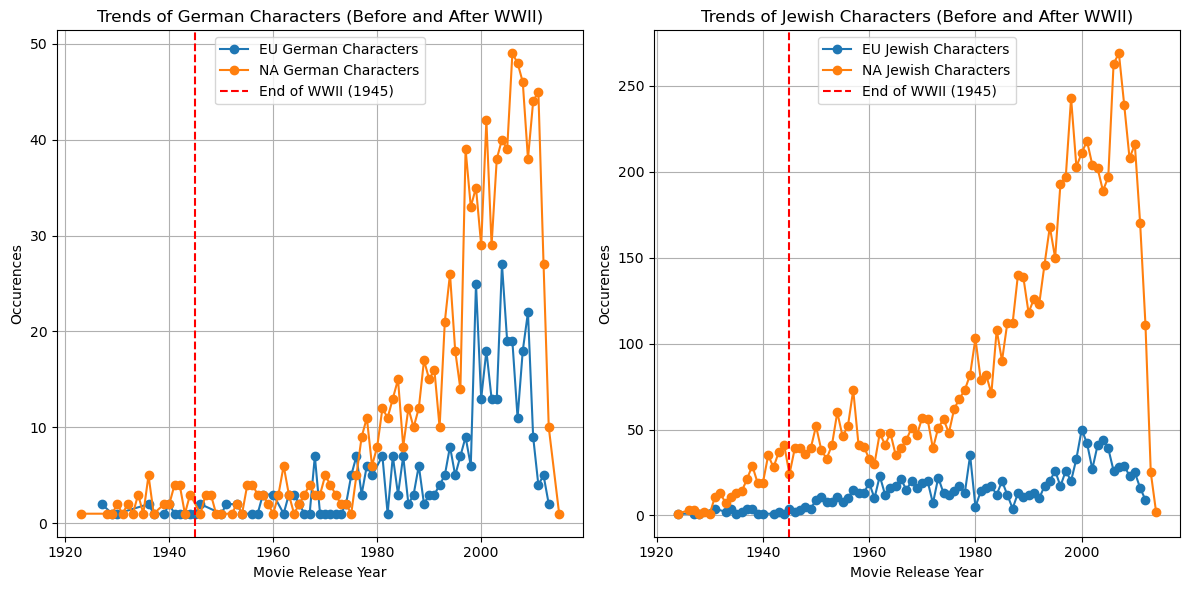

In [79]:
plot_absolute_trend_character(character_EU, character_NA)

We look at the general trend in Europer and in North America of total occurences of German and Jewish representation in character of the movies. We observe number of German character seems to not be affect by the war neither in Europe or in North America. The trend of Jewish people seems to follow the same increasing tendency before and after the war in North America. However we observe it reach a plateau around 1945. The number of Jewish people representation in Europe seems to start after the war, however the increase in Jewish character representation is more increasing for North America than for Europe. However, with the absolute occurence we could not draw any conclusion because the number of movies is also increasing. 

To further investigate those trends we will look at the proportions.

In [80]:
def plot_proportion_trend(character_EU,character_NA):
    """
    This function plots the trends of German and Jewish characters' proportions in movies 
    before and after World War II for both Europe (EU) and North America (NA).

    Args:
        character_EU (DataFrame): DataFrame containing movie characters in Europe with columns:
            - 'Ethnicity_Label' (e.g., 'German', 'Jewish')
            - 'Movie_Release_Year' (release year of the movie)
        character_NA (DataFrame): DataFrame containing movie characters in North America with similar columns.
    
    Returns:
        None: Displays plots showing trends.
    """
    #Isolate European and North American character
    character_EU_German = character_EU[character_EU['Ethnicity_Label'].str.contains('German') ]
    character_EU_Jewish = character_EU[character_EU['Ethnicity_Label'].str.contains('Jewish')]
    character_NA_German = character_NA[character_NA['Ethnicity_Label'].str.contains('German')]
    character_NA_Jewish = character_NA[character_NA['Ethnicity_Label'].str.contains('Jewish')]

    #Look at the general trend of Jewish and German character before and after world war 2
    eu_german_trend = character_EU_German.groupby('Movie_Release_Year').size()/character_EU.groupby('Movie_Release_Year').size()
    eu_jewish_trend = character_EU_Jewish.groupby('Movie_Release_Year').size()/character_EU.groupby('Movie_Release_Year').size()
    na_german_trend = character_NA_German.groupby('Movie_Release_Year').size()/character_NA.groupby('Movie_Release_Year').size()
    na_jewish_trend = character_NA_Jewish.groupby('Movie_Release_Year').size()/character_NA.groupby('Movie_Release_Year').size()

    # Plot trends
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plot_trend(eu_german_trend,na_german_trend,'EU German Characters','NA German Characters','Trends of German Characters (Before and After WWII)')

    plt.subplot(1,2,2)
    plot_trend(eu_jewish_trend,na_jewish_trend,'EU Jewish Characters','NA Jewish Characters','Trends of Jewish Characters (Before and After WWII)')

    plt.tight_layout()
    plt.show()


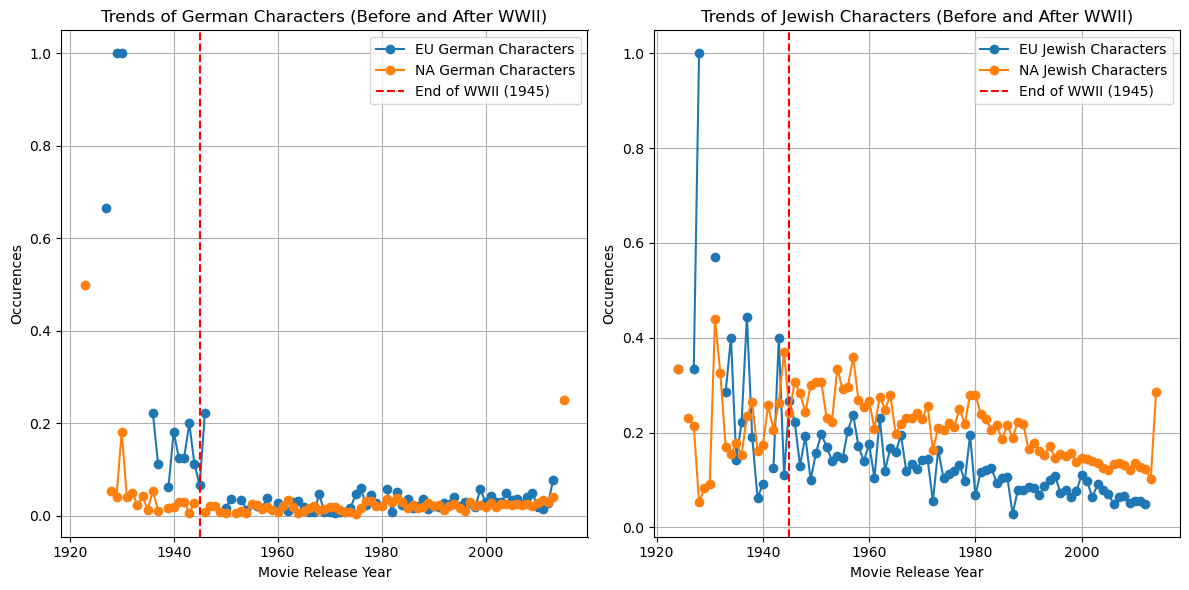

In [81]:
plot_proportion_trend(character_EU, character_NA)

Analyzing the proportions, we observe a slight decline in the representation of German characters both in North America and Europe before and after WWII. Interestingly, there is also a notable decrease in the representation of Jewish characters following the war in both regions, but strongly in Europe. This trend, which was already present before the war, appears to have been exacerbated by it. The underrepresentation of German characters post-WWII could be attributed to Germany's damaged international reputation at the time. 
Additionally, the decline in Jewish character representation is more pronounced in Europe than in North America, possibly reflecting the stronger prevalence of antisemitism in Europe slightly before and after the war. Finally, another possible factor is the migration of Jews during the war to North America to escape the european antisemitism. All this factor can explained the decrease in Jewish representation after the war. 